In [1]:
import pandas as pd
import numpy as np
import json
# plotting
import os
import pathlib
import warnings
import statsmodels.api as sm
import statsmodels.formula.api as smf
from mplsoccer import Pitch
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

# Get the data

In [2]:
notebook_dir = pathlib.Path().absolute()
events_path = os.path.join(notebook_dir.parent, "wyscout-data", "events", "events_England.json")

with open(events_path) as f:
    events = json.load(f)

df = pd.DataFrame(events)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 643150 entries, 0 to 643149
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   eventId       643150 non-null  int64  
 1   subEventName  643150 non-null  object 
 2   tags          643150 non-null  object 
 3   playerId      643150 non-null  int64  
 4   positions     643150 non-null  object 
 5   matchId       643150 non-null  int64  
 6   eventName     643150 non-null  object 
 7   teamId        643150 non-null  int64  
 8   matchPeriod   643150 non-null  object 
 9   eventSec      643150 non-null  float64
 10  subEventId    643150 non-null  object 
 11  id            643150 non-null  int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 58.9+ MB


# Preparing the data

In [3]:
# Get at next event
next_event = df.shift(-1, fill_value=0)

# Set nextEvent and kickedOut
df["nextEvent"] = next_event["subEventName"]
df["kickedOut"] = df.apply(lambda x: 1 if x["nextEvent"] == "Ball out of the field" else 0, axis=1)

# Drop interruptions
interruptions = df[df["eventName"] == "Interruption"]
df = df.drop(interruptions.index)

# Drop non-accurate duels (wyscout saves two: attacking and defending)
lost_duels = df[df["eventName"] == "Duel"]
lost_duels = lost_duels[lost_duels.apply(lambda x: {"id": 1802} in x["tags"], axis = 1)]
df = df.drop(lost_duels.index)

# Drop ball out of field
out_of_fields = df[df["subEventName"] == "Ball out of the field"]
df = df.drop(out_of_fields.index)

# Drop save attempts
save_attempts = df[df["subEventName"].isin(["Goalkeeper leaving line", "Save attempt", "Reflexes"])]
df = df.drop(save_attempts.index)

df.shape

(542524, 14)

# Isolating possession chains

In [4]:
def isolateChains(df):
    """
    Takes a dataframe with Wyscout event data.

    Returns a dataframe with isolated possesion chains

    """
    # Add new column with team id's of the next event
    df["nextTeamId"] = df.shift(-1, fill_value=0)["teamId"]

    # Init variables
    chain = 0
    chain_team = df.iloc[0]["teamId"]
    period = df.iloc[0]["matchPeriod"]
    stop_criterion = 0
    df["possession_chain"] = 0
    df["possession_chain_team"] = 0

    for i, row in df.iterrows():
        # Set the chain number and team
        df.at[i, "possession_chain"] = chain
        df.at[i, "possession_chain_team"] = chain_team

        # If pass is not accurate or it's a lost duel, add 1 to stop criterion
        if row["eventName"] == "Pass" or row["eventName"] == "Duel":
            if row["teamId"] == chain_team and {"id": 1802} in row["tags"]:
                    stop_criterion += 1
            if row["teamId"] != chain_team and {"id": 1801} in row["tags"]:
                    stop_criterion += 1

        # If ball is intercepted properly, add 2 to stop criterion
        if row["eventName"] == "Others on the ball":
            if row["teamId"] == row["nextTeamId"]:
                stop_criterion += 2

        # If actions is over thanks to a shot, foul or offside: add 2 to stop criterion
        if row["eventName"] in ["Shot", "Foul", "Offside"]:
            stop_criterion += 2

        # If ball is out of field, add 2 to stop criterion
        if row["kickedOut"] == 1:
            stop_criterion += 2
            
        # If period ended, reset variables
        if row["matchPeriod"] != period:
            chain += 1
            stop_criterion = 0
            chain_team = row['teamId']
            period = row["matchPeriod"]
            df.at[i, "possession_chain"] = chain
            df.at[i, "possession_chain_team"] = chain_team

        # If stop criterion is 2 or more, add 1 to chain number and reset stop criterion
        if stop_criterion >= 2:
            chain += 1
            stop_criterion = 0
            chain_team = row['nextTeamId']

    return df

df = isolateChains(df)

In [5]:
# Check a chain
df[df["possession_chain"] == 4][["eventName", "possession_chain"]]

,eventName,possession_chain
36,Free Kick,4
37,Pass,4
38,Duel,4
40,Duel,4
42,Pass,4
43,Pass,4
44,Pass,4
45,Pass,4
46,Shot,4


# Prepare data for modelling

- Filtering out events without end coordinates
- Store coordinates in seperate columns
- Create c-variable (distance to horizontal line through the middle of the pitch)
- Set end of shot coordinates to (105, 34)

In [17]:
# Filter out events without end coordinates
df = df[df.apply(lambda x: len(x["positions"]) == 2, axis = 1)]

# Store coordinates in seperate columns
df["x0"] = df["positions"].apply(lambda cell: (cell[0]["x"]) * 105/100)
df["x1"] = df["positions"].apply(lambda cell: (cell[1]["x"]) * 105/100)
df["c0"] = df["positions"].apply(lambda cell: abs(50 - cell[0]["y"]) * 68/100)
df["c1"] = df["positions"].apply(lambda cell: abs(50 - cell[1]["y"]) * 68/100)

# Assing correct coordinates to shot events
df.loc[df["eventName"] == "Shot", "x1"] = 105
df.loc[df["eventName"] == "Shot", "c1"] = 0

# Set y coordinates (only used for plotting)
df["y0"] = df["positions"].apply(lambda cell: (100 - cell[0]["y"]) * 68/100)
df["y1"] = df["positions"].apply(lambda cell: (100 - cell[1]["y"]) * 68/100)
df.loc[df["eventName"] == "Shot", "y1"] = 34

df.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,...,kickedOut,nextTeamId,possession_chain,possession_chain_team,x0,x1,c0,c1,y0,y1
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,...,0,1609,0,1609,51.45,32.55,0.68,19.04,34.68,14.96
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,...,0,1609,0,1609,32.55,53.55,19.04,17.00,14.96,17.00
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,...,0,1609,0,1609,53.55,36.75,17.00,14.28,17.00,19.72
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,...,0,1609,0,1609,36.75,43.05,14.28,30.60,19.72,3.40
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,...,0,1609,0,1609,43.05,75.60,30.60,25.84,3.40,8.16


# Plot a possession chain

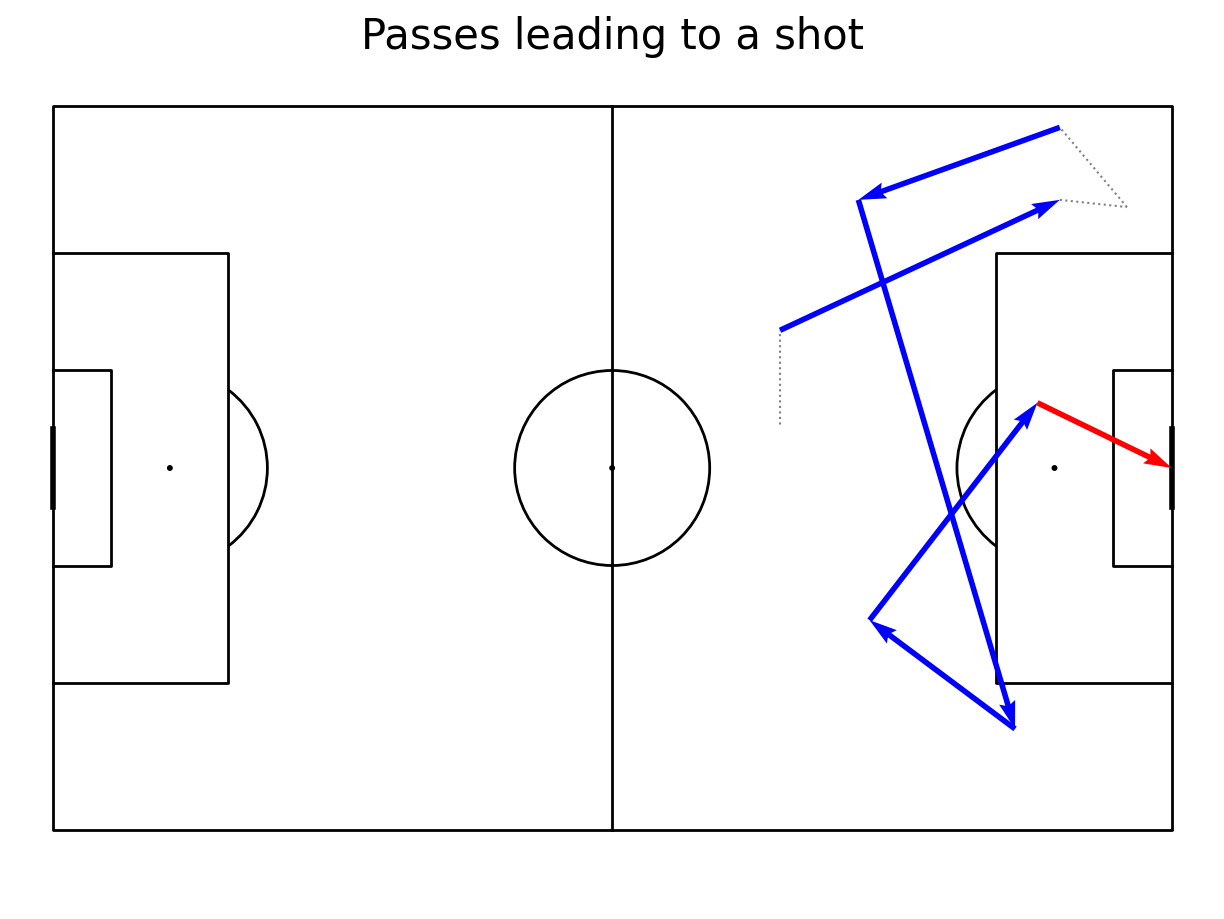

In [18]:
# Get chain
chain = df[df["possession_chain"] == 4]

# Split passes and other events
passes = chain[chain["eventName"] == "Pass"]
not_passes = chain[chain["eventName"] != "Pass"]

# Get shot (is the last event in chain)
shot = chain.iloc[-1]

# Init plot
pitch = Pitch(line_color='black',pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

# Plot passes
pitch.arrows(passes["x0"], passes["y0"], passes["x1"], passes["y1"], ax=ax["pitch"], color="blue", zorder=3)

# Plot shot
pitch.arrows(shot["x0"], shot["y0"], shot["x1"], shot["y1"], ax=ax["pitch"], color="red", zorder=3)

# Plot other events
pitch.lines(not_passes["x0"], not_passes["y0"], not_passes["x1"], not_passes["y1"], ax=ax["pitch"], color="grey", lw=1.5, ls="dotted")

ax['title'].text(0.5, 0.5, 'Passes leading to a shot', ha='center', va='center', fontsize=30)
plt.show()
